# SYDE 572: Assignment 4
Elizabeth Janes

In [1]:
!python --version

Python 3.7.15


## General Utility Functions

In [15]:
def get_first_600_indices(labels, target_label):
    class_indices = np.where(labels == target_label)
    class_indices_600 = class_indices[0]
    class_indices_600 = class_indices_600[:600]

    return class_indices_600


def get_subset_data(data, labels):
    idx_0 = get_first_600_indices(labels, 0)
    idx_1 = get_first_600_indices(labels, 1)
    idx_2 = get_first_600_indices(labels, 2)
    idx_3 = get_first_600_indices(labels, 3)
    idx_4 = get_first_600_indices(labels, 4)
    idx_5 = get_first_600_indices(labels, 5)
    idx_6 = get_first_600_indices(labels, 6)
    idx_7 = get_first_600_indices(labels, 7)
    idx_8 = get_first_600_indices(labels, 8)
    idx_9 = get_first_600_indices(labels, 9)

    idx = np.concatenate((idx_0, idx_1, idx_2,  idx_3, idx_4, idx_5, idx_6, idx_7, idx_8, idx_9))
    idx = np.sort(idx)

    return idx

def get_model_predictions(model, num_classes, data_loader, device):
  model.eval()
  conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
  with torch.no_grad():
      for data, targets in data_loader:
          data = data.to(device)
          targets = targets.to(device)

          # forward pass
          logits = model(data)

          # get class predictions
          pred_classes = torch.argmax(logits, dim=1)

          # update confusion matrix
          for target, prediction in zip(targets, pred_classes):
              conf_matrix[target, prediction] += 1

  accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()

  return accuracy, conf_matrix


def plot_confusion_matrix(accuracy, conf_matrix, num_classes):
    print('\nTest Accuracy: {} %'.format(accuracy * 100))
    plt.figure()
    plt.imshow(conf_matrix, cmap='Reds')
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')
    plt.xlabel('Predicted')
    plt.ylabel('Ground-truth')
    plt.show()


def plot_loss_curve(losses, title, xlabel):
    plt.figure()
    plt.plot(losses, 'r-')
    plt.xlabel(xlabel)
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


def plot_epoch_accuracy(epoch_accuracy, title):
    plt.figure()
    plt.plot(epoch_accuracy, 'r-')
    plt.xlabel('Number of Training Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

# Exercise 1

## Question 1 and Question 2


[epoch: 8, step: 49, loss: 1.085488200187683]
[epoch: 16, step: 99, loss: 0.1682399958372116]
[epoch: 24, step: 149, loss: 0.07499711960554123]
[epoch: 33, step: 199, loss: 0.04015091061592102]

Test Accuracy: 97.8 %


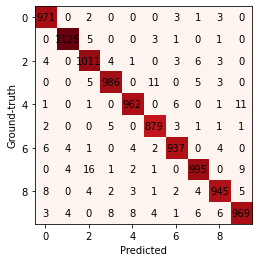

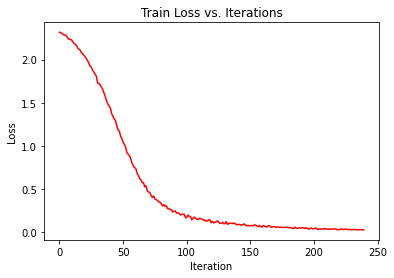

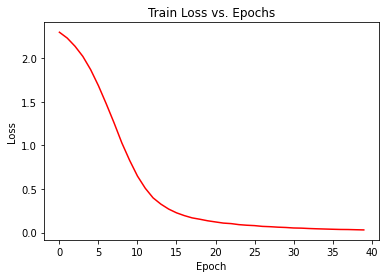

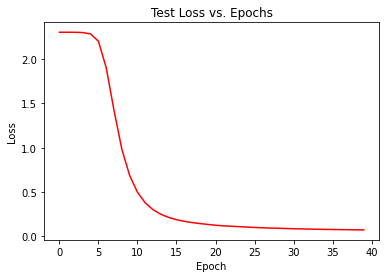

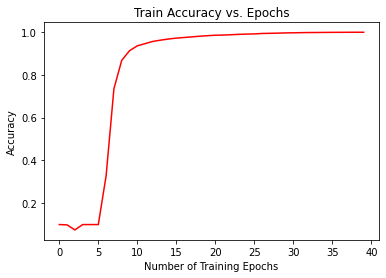

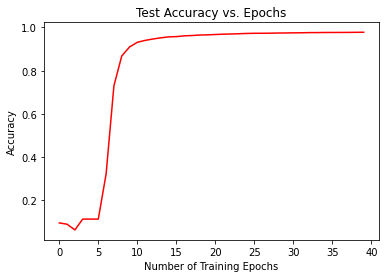

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.1_cnn_model_weights.pth')

## Question 3

### Data augmentation: random horizontal flip


Test Accuracy: 42.33 %


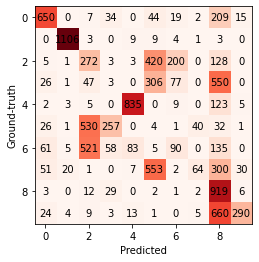

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.RandomHorizontalFlip(p=1),
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load previously learned weights instead of re-training
state_dict_loaded = torch.load('1.1_cnn_model_weights.pth')
# And we can load the weights back into the model using:
model.load_state_dict(state_dict_loaded)

# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)

### Data augmentation: random horizontal flip plus Gaussian blur



Test Accuracy: 32.82 %


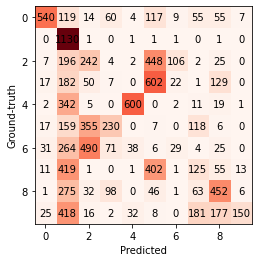

In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.RandomHorizontalFlip(p=1),
    T.GaussianBlur(3),
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load previously learned weights instead of re-training
state_dict_loaded = torch.load('1.1_cnn_model_weights.pth')
# And we can load the weights back into the model using:
model.load_state_dict(state_dict_loaded)

# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)

### Data augmentation: random vertical flip


Test Accuracy: 36.91 %


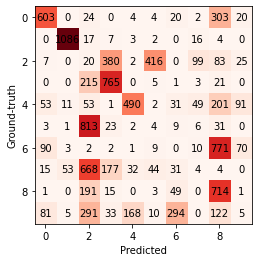

In [6]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.RandomVerticalFlip(p=1),
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load previously learned weights instead of re-training
state_dict_loaded = torch.load('1.1_cnn_model_weights.pth')
# And we can load the weights back into the model using:
model.load_state_dict(state_dict_loaded)

# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)

### Data augmentation: random vertical flip plus Gaussian blur


Test Accuracy: 28.43 %


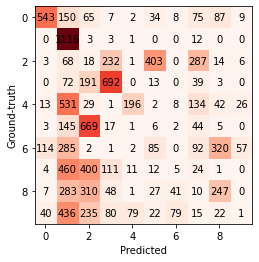

In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.RandomVerticalFlip(p=1),
    T.GaussianBlur(3),
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load previously learned weights instead of re-training
state_dict_loaded = torch.load('1.1_cnn_model_weights.pth')
# And we can load the weights back into the model using:
model.load_state_dict(state_dict_loaded)

# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)

## Question 4

### RMSprop (40 epochs)

[epoch: 8, step: 49, loss: 2.2084431648254395]
[epoch: 16, step: 99, loss: 1.9370300769805908]
[epoch: 24, step: 149, loss: 1.872857689857483]
[epoch: 33, step: 199, loss: 1.7073677778244019]

Test Accuracy: 26.99 %


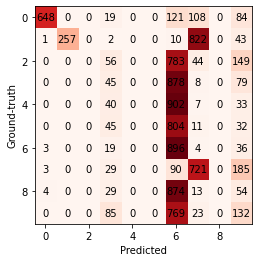

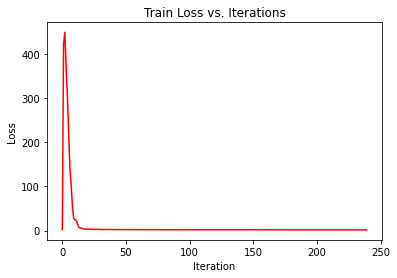

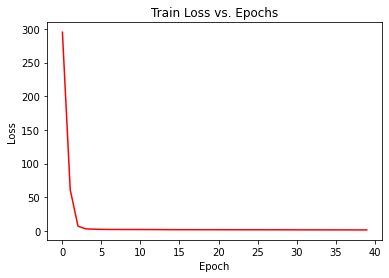

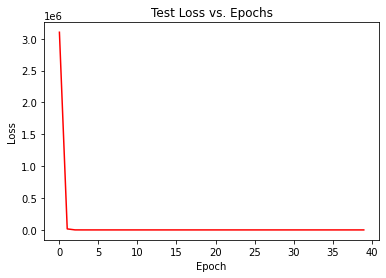

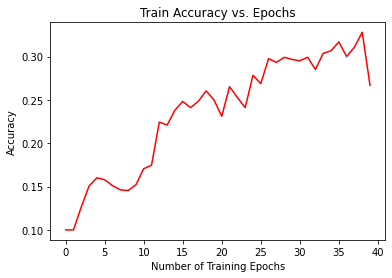

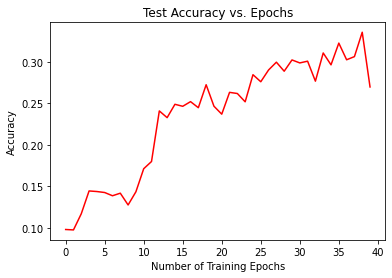

In [8]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    # epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    # loss_per_epoch.append(epoch_average_loss)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.3_rmsprop_model_weights.pth')

### RMSprop (120 epochs)

[epoch: 8, step: 49, loss: 2.2119486331939697]
[epoch: 16, step: 99, loss: 2.19381046295166]
[epoch: 24, step: 149, loss: 2.135964870452881]
[epoch: 33, step: 199, loss: 2.077880382537842]
[epoch: 41, step: 249, loss: 1.8453444242477417]
[epoch: 49, step: 299, loss: 1.7497957944869995]
[epoch: 58, step: 349, loss: 1.4865615367889404]
[epoch: 66, step: 399, loss: 1.2722043991088867]
[epoch: 74, step: 449, loss: 1.0179264545440674]
[epoch: 83, step: 499, loss: 0.42514070868492126]
[epoch: 91, step: 549, loss: 0.19406333565711975]
[epoch: 99, step: 599, loss: 0.12134311348199844]
[epoch: 108, step: 649, loss: 0.0548970028758049]
[epoch: 116, step: 699, loss: 0.10124485194683075]

Test Accuracy: 95.39999999999999 %


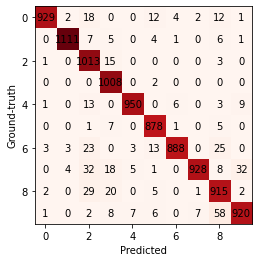

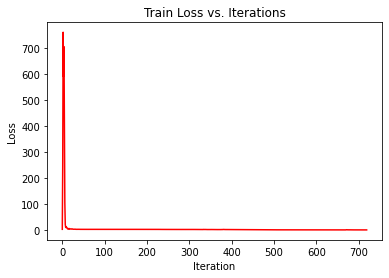

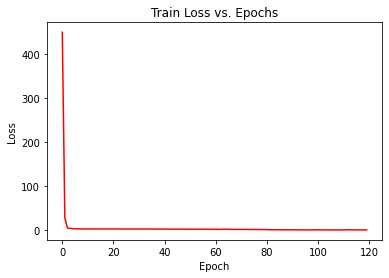

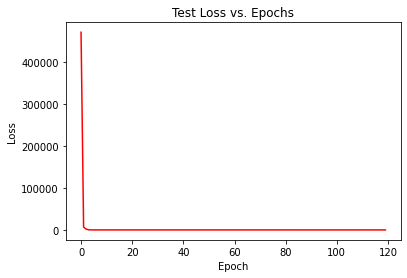

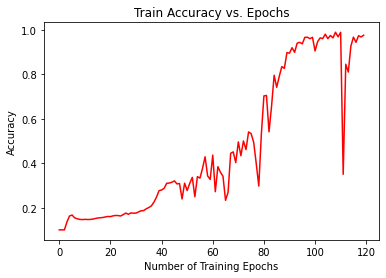

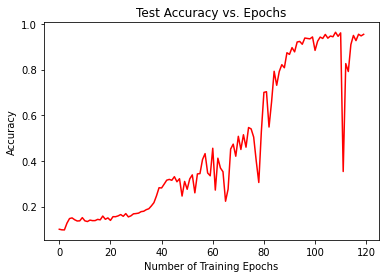

In [19]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 120
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    # epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    # loss_per_epoch.append(epoch_average_loss)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.3_rmsprop_model_weights.pth')

### Adam

[epoch: 8, step: 49, loss: 0.9729588627815247]
[epoch: 16, step: 99, loss: 0.20628447830677032]
[epoch: 24, step: 149, loss: 0.032189469784498215]
[epoch: 33, step: 199, loss: 0.004402512218803167]
[epoch: 41, step: 249, loss: 0.004036786500364542]
[epoch: 49, step: 299, loss: 0.0006223708624020219]
[epoch: 58, step: 349, loss: 0.0005435798084363341]
[epoch: 66, step: 399, loss: 0.027444634586572647]
[epoch: 74, step: 449, loss: 0.007874076254665852]
[epoch: 83, step: 499, loss: 0.008425392210483551]
[epoch: 91, step: 549, loss: 0.002752403961494565]
[epoch: 99, step: 599, loss: 9.584588406141847e-05]
[epoch: 108, step: 649, loss: 0.0013038965407758951]
[epoch: 116, step: 699, loss: 8.686028741067275e-05]

Test Accuracy: 98.26 %


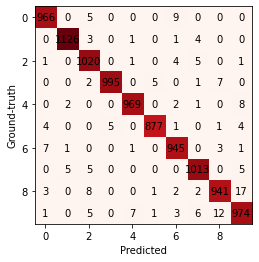

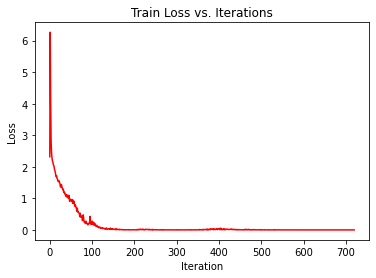

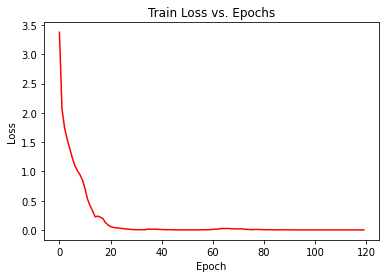

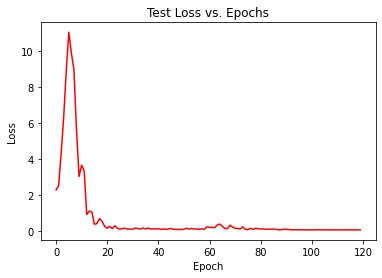

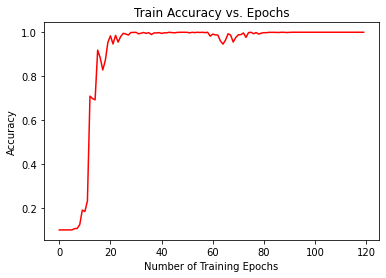

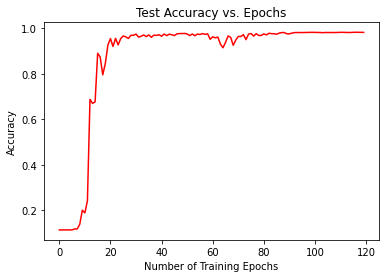

In [18]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 120
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.3_adam_model_weights.pth')

## Question 5

[epoch: 8, step: 49, loss: 2.352388620376587]
[epoch: 16, step: 99, loss: 2.341305732727051]
[epoch: 24, step: 149, loss: 2.3432114124298096]
[epoch: 33, step: 199, loss: 2.3353471755981445]

Test Accuracy: 10.32 %


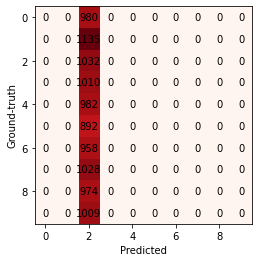

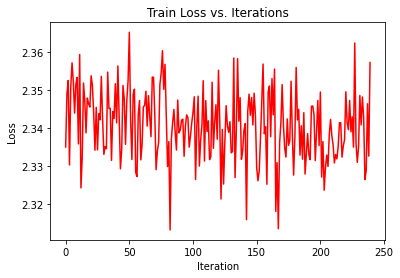

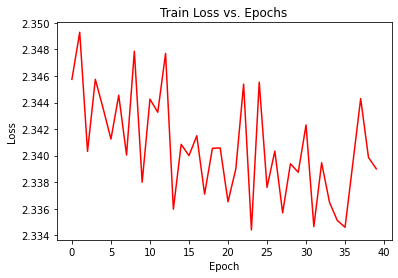

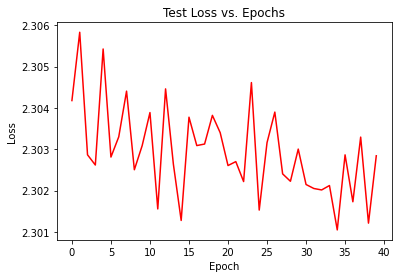

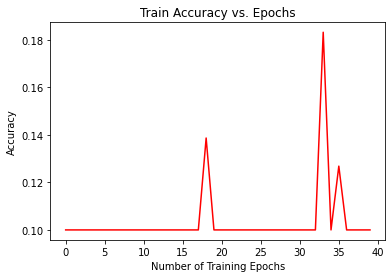

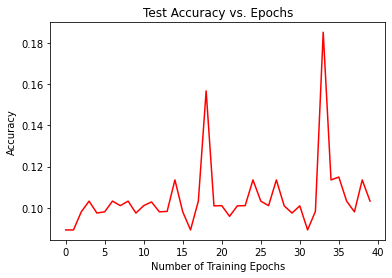

In [11]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.Sigmoid(),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.Sigmoid(),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.Sigmoid(),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.Sigmoid(),
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), 
    nn.Sigmoid(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.5_sigmoid_model_weights.pth')

## Question 6

[epoch: 8, step: 49, loss: 0.7674061059951782]
[epoch: 16, step: 99, loss: 0.1458972543478012]
[epoch: 24, step: 149, loss: 0.06246453523635864]
[epoch: 33, step: 199, loss: 0.03221777454018593]

Test Accuracy: 97.76 %


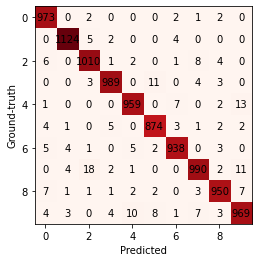

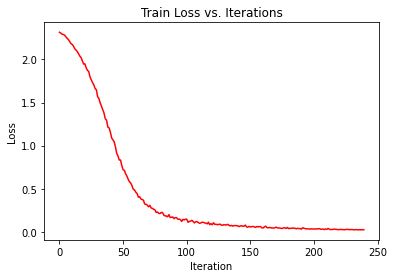

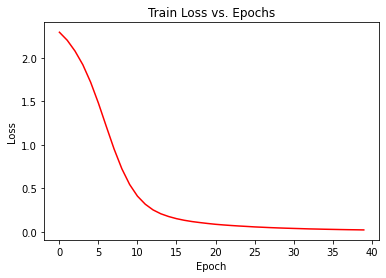

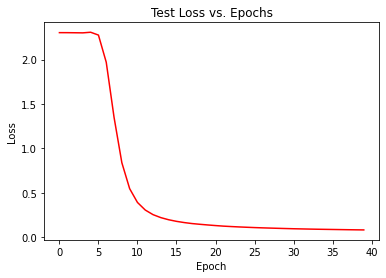

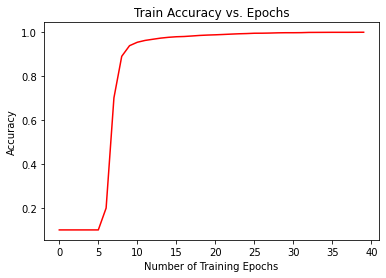

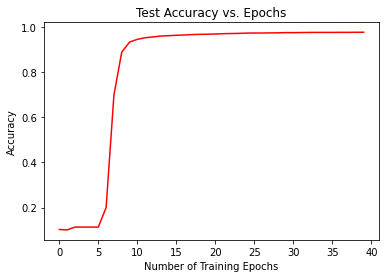

In [12]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([ 
    T.Resize((32, 32)),
    T.ToTensor()
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True), 
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace=True), 
    nn.Linear(4096, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '1.6_no_dropout_model_weights.pth')

# Exercise 2

## Question 1 and Question 2

[epoch: 8, step: 49, loss: 0.7346178889274597]
[epoch: 16, step: 99, loss: 0.5114967226982117]
[epoch: 24, step: 149, loss: 0.40262603759765625]
[epoch: 33, step: 199, loss: 0.32653284072875977]

Test Accuracy: 90.66 %


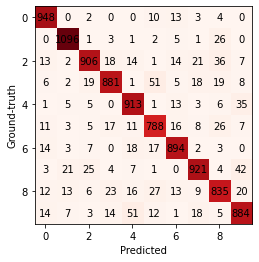

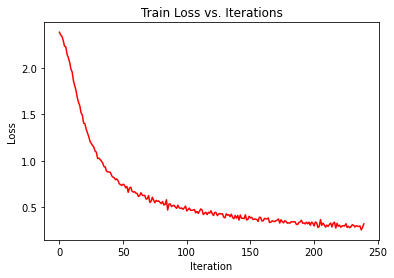

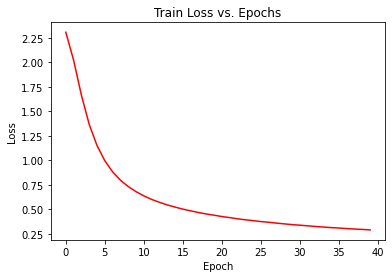

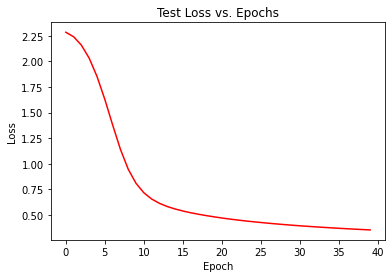

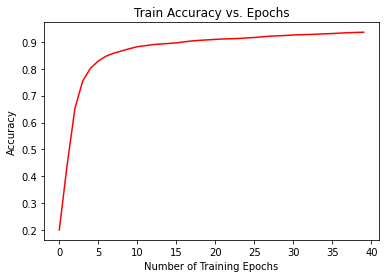

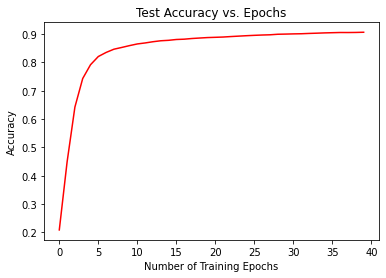

In [13]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    # epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    # loss_per_epoch.append(epoch_average_loss)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '2.1_mlp_model_weights.pth')

## Question 3

## Question 4

[epoch: 8, step: 49, loss: 0.7231571674346924]
[epoch: 16, step: 99, loss: 0.4110361933708191]
[epoch: 24, step: 149, loss: 0.31809261441230774]
[epoch: 33, step: 199, loss: 0.23825417459011078]

Test Accuracy: 91.83 %


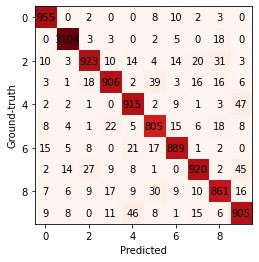

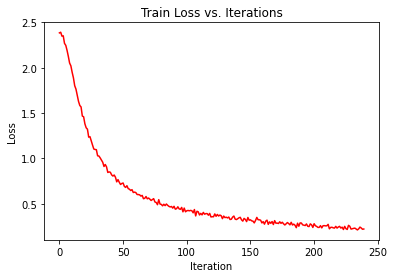

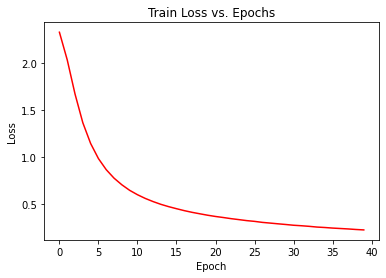

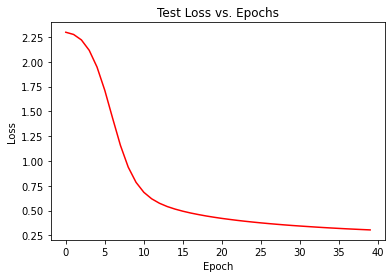

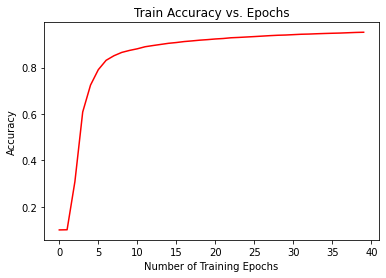

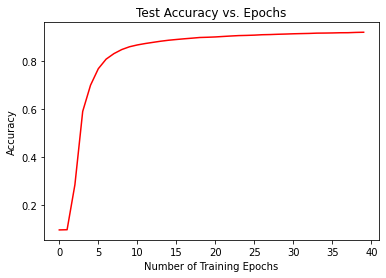

In [14]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


num_classes = 10  # 10 MNIST classes to categorize data into
batch_size = 1024  # size of mini-batch
epoch_count = 40
device = 'cuda:0'
print_interval = 50

# Make datasets
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'train')
test_data_dir = os.path.join(project_dir, 'test')
train_dataset_full = MNIST(root=train_data_dir, transform=transform, download=True, train=True)
subset_idx = get_subset_data(train_dataset_full.data.numpy(), train_dataset_full.targets.numpy())
train_dataset = torch.utils.data.Subset(train_dataset_full, subset_idx)
test_dataset = MNIST(root=test_data_dir, transform=transform, download=True, train=False)

# Make model
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10)
)
model.to(device)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Loss Function
loss_func = nn.CrossEntropyLoss()

step = 0  # track iterations
losses = []  # track loss at each iteration
test_epoch_accuracy = []
train_loss_per_epoch = []
train_epoch_accuracy = []
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epoch_count):
    train_epoch_loss = []
    train_epoch_loss = []
    for data, targets in train_loader:
        model.train()
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # reset gradients

        logits = model(data)

        loss = loss_func(logits, targets)

        # back propagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_epoch_loss.append(loss.item())
        if not (step + 1) % print_interval:
            print('[epoch: {}, step: {}, loss: {}]'.format(epoch, step, loss.item()))

        step += 1
    test_accuracy, test_epoch_confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
    test_epoch_accuracy.append(test_accuracy)
    epoch_average_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    train_loss_per_epoch.append(epoch_average_loss)

    train_accuracy, train_epoch_confusion_matrix = get_model_predictions(model, num_classes, train_loader, device)
    train_epoch_accuracy.append(train_accuracy)
    # epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    # loss_per_epoch.append(epoch_average_loss)
    epoch_test_loss = []
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      logits = model(data)
      loss = loss_func(logits, targets)
      epoch_test_loss.append(loss.item())
    epoch_average_test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
    test_loss_per_epoch.append(epoch_average_test_loss)


# Test Accuracy
# Predictions
accuracy, confusion_matrix = get_model_predictions(model, num_classes, test_loader, device)
# print(accuracy)
plot_confusion_matrix(accuracy, confusion_matrix, num_classes)
# Plot loss curves
plot_loss_curve(losses, 'Train Loss vs. Iterations', 'Iteration')
plot_loss_curve(train_loss_per_epoch, 'Train Loss vs. Epochs', 'Epoch')
plot_loss_curve(test_loss_per_epoch, 'Test Loss vs. Epochs', 'Epoch')
plot_epoch_accuracy(train_epoch_accuracy, 'Train Accuracy vs. Epochs')
plot_epoch_accuracy(test_epoch_accuracy, 'Test Accuracy vs. Epochs')

state_dict = model.state_dict()
torch.save(state_dict, '2.4_mlp_model_weights.pth')